### CIFAR10 `pyTorch`

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

def load_cifar10():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    return train_dataset, test_dataset

# Загрузка данных
train_dataset, test_dataset = load_cifar10()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [44]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.2)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.dropout1(self.pool(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.dropout2(self.pool(F.relu(self.conv4(F.relu(self.conv3(x))))))
        x = self.dropout3(self.pool(F.relu(self.conv6(F.relu(self.conv5(x))))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout4(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Текущее устройство:", device)
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.4f} --> {val_loss:.4f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_score = val_loss

num_epochs = 100
early_stopping = EarlyStopping(patience=10, verbose=True)


Текущее устройство: cuda


In [45]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {(running_loss / len(train_loader)):.3f}, Точность (train): {train_accuracy:.3f}')
    model.eval()
    val_loss = 0.0
    correct_val = 0 
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Подсчет правильных предсказаний
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val  # Точность на тестовом наборе
    val_loss /= len(test_loader)
    print(f'Потери на тестовом наборе: {val_loss:.4f}, Точность (val): {val_accuracy:.4f}')

    # Проверка условия EarlyStopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Восстановление лучших весов
model.load_state_dict(torch.load('checkpoint.pt'))

Эпоха [1/100], Потери: 1.659, Точность (train): 0.377
Потери на тестовом наборе: 1.3124, Точность (val): 0.5194
Validation loss decreased (1.3124 --> 1.3124). Saving model...
Эпоха [2/100], Потери: 1.222, Точность (train): 0.559
Потери на тестовом наборе: 1.0280, Точность (val): 0.6299
Validation loss decreased (1.0280 --> 1.0280). Saving model...
Эпоха [3/100], Потери: 1.033, Точность (train): 0.632
Потери на тестовом наборе: 0.8815, Точность (val): 0.6893
Validation loss decreased (0.8815 --> 0.8815). Saving model...
Эпоха [4/100], Потери: 0.907, Точность (train): 0.681
Потери на тестовом наборе: 0.8484, Точность (val): 0.7050
Validation loss decreased (0.8484 --> 0.8484). Saving model...
Эпоха [5/100], Потери: 0.821, Точность (train): 0.711
Потери на тестовом наборе: 0.7557, Точность (val): 0.7373
Validation loss decreased (0.7557 --> 0.7557). Saving model...
Эпоха [6/100], Потери: 0.765, Точность (train): 0.731
Потери на тестовом наборе: 0.7130, Точность (val): 0.7508
Validation lo

<All keys matched successfully>

Точность на тестовом наборе: 81.090 %


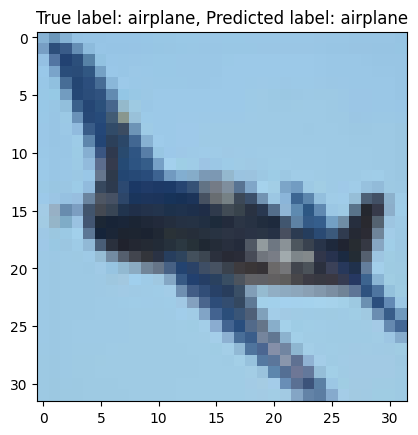

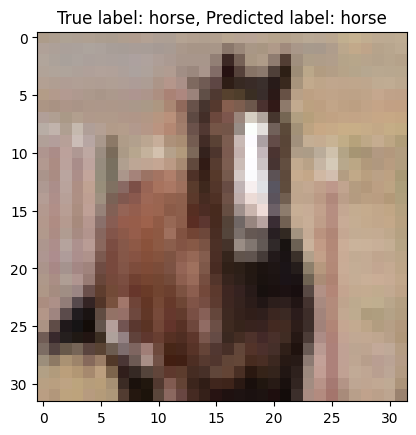

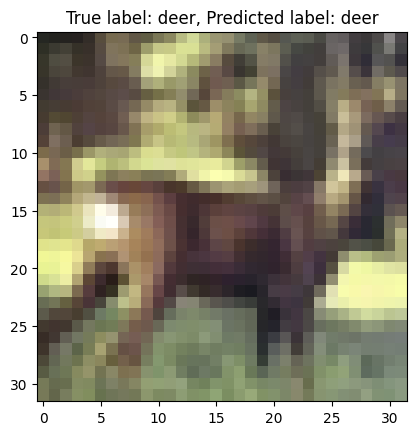

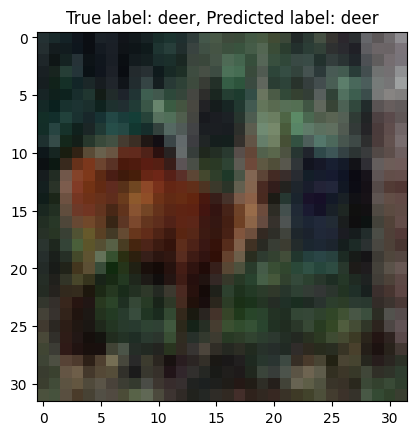

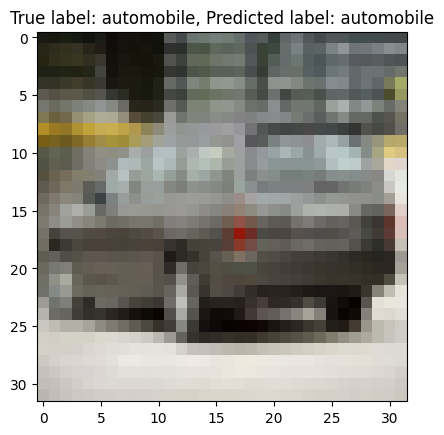

In [50]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

model = SimpleCNN().to(device)
model.load_state_dict(torch.load('checkpoint.pt'))
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Точность на тестовом наборе: {(accuracy)*100:.3f} %')

# Визуализация предсказаний для нескольких изображений
def to_pil(image_tensor):
    image_tensor = image_tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
    image_tensor = (image_tensor + 1) / 2.0
    return Image.fromarray((image_tensor * 255).astype(np.uint8))

def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    random_indices = random.sample(range(len(test_loader.dataset)), num_images)

    with torch.no_grad():
        for idx in random_indices:
            image, label = test_loader.dataset[idx]
            image = image.unsqueeze(0).to(device)
            output = model(image)
            _, predicted = torch.max(output.data, 1)

            image_pil = to_pil(image.squeeze())

            plt.imshow(image_pil)
            plt.title(f"True label: {class_mapping[label]}, Predicted label: {class_mapping[predicted.item()]}")
            plt.show()

# Визуализация предсказаний для нескольких изображений из тестового набора
visualize_predictions(model, test_loader, num_images=5)